In [ ]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt




ROOT_DATA_DIR = os.path.join('..', 'Data')


INPUT_MASKS_DIR = os.path.join(ROOT_DATA_DIR, 'PROCESSED_DEFECT_MASKS')


ORIGINAL_IMAGES_DIR = os.path.join(ROOT_DATA_DIR, 'PCB_DATASET', 'images')


OUTPUT_ROIS_DIR = os.path.join(ROOT_DATA_DIR, 'CLASSIFICATION_ROIS_128x128')


DEFECT_TYPES = ['Missing_hole', 'Mouse_bite', 'Open_circuit', 'Short', 'Spur', 'Spurious_copper']


TARGET_SIZE = (128, 128)
MIN_DEFECT_AREA = 100 

os.makedirs(OUTPUT_ROIS_DIR, exist_ok=True)

print(f"Input Masks Dir: {INPUT_MASKS_DIR}")
print(f"Output ROIs Dir: {OUTPUT_ROIS_DIR}")
print(f"Target ROI Size: {TARGET_SIZE}")

Input Masks Dir: ..\Data\PROCESSED_DEFECT_MASKS
Output ROIs Dir: ..\Data\CLASSIFICATION_ROIS_128x128
Target ROI Size: (128, 128)


In [ ]:
def extract_and_save_rois(mask_path, original_img_path, defect_label):
    """
    Detects contours in the mask, crops the ROI from the original image, 
    resizes it, and saves it with the correct label.
    """
    

    mask = cv2.imread(mask_path, 0)
    original_img = cv2.imread(original_img_path)
    
    if mask is None or original_img is None:
        return 0, None 

 
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
 
    save_dir = os.path.join(OUTPUT_ROIS_DIR, defect_label)
    os.makedirs(save_dir, exist_ok=True)
    
    roi_count = 0
    viz_image = original_img.copy() 

    for i, contour in enumerate(contours):
     
        if cv2.contourArea(contour) < MIN_DEFECT_AREA: 
            continue

   
        x, y, w, h = cv2.boundingRect(contour)
        
        
        padding = 10 
        x1 = max(0, x - padding)
        y1 = max(0, y - padding)
        x2 = min(original_img.shape[1], x + w + padding)
        y2 = min(original_img.shape[0], y + h + padding)
        
       
        cropped_roi = original_img[y1:y2, x1:x2]
        
        if cropped_roi.size == 0:
             continue

       
        final_roi = cv2.resize(cropped_roi, TARGET_SIZE, interpolation=cv2.INTER_LINEAR)

      
        roi_filename = f"{defect_label}_{os.path.basename(original_img_path).replace('.JPG', '').replace('.jpg', '')}_{i}.png"
        
        
        cv2.imwrite(os.path.join(save_dir, roi_filename), final_roi)
        
        roi_count += 1

    
        cv2.rectangle(viz_image, (x1, y1), (x2, y2), (0, 0, 255), 3) 
        cv2.putText(viz_image, defect_label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
        
    return roi_count, viz_image


Starting Contour Detection for defect type: Missing_hole

Starting Contour Detection for defect type: Mouse_bite

Starting Contour Detection for defect type: Open_circuit

Starting Contour Detection for defect type: Short

Starting Contour Detection for defect type: Spur

Starting Contour Detection for defect type: Spurious_copper


--- TOTAL ROIs Extracted and Saved: 3057 ---
Displaying a sample detection result for each defect type.


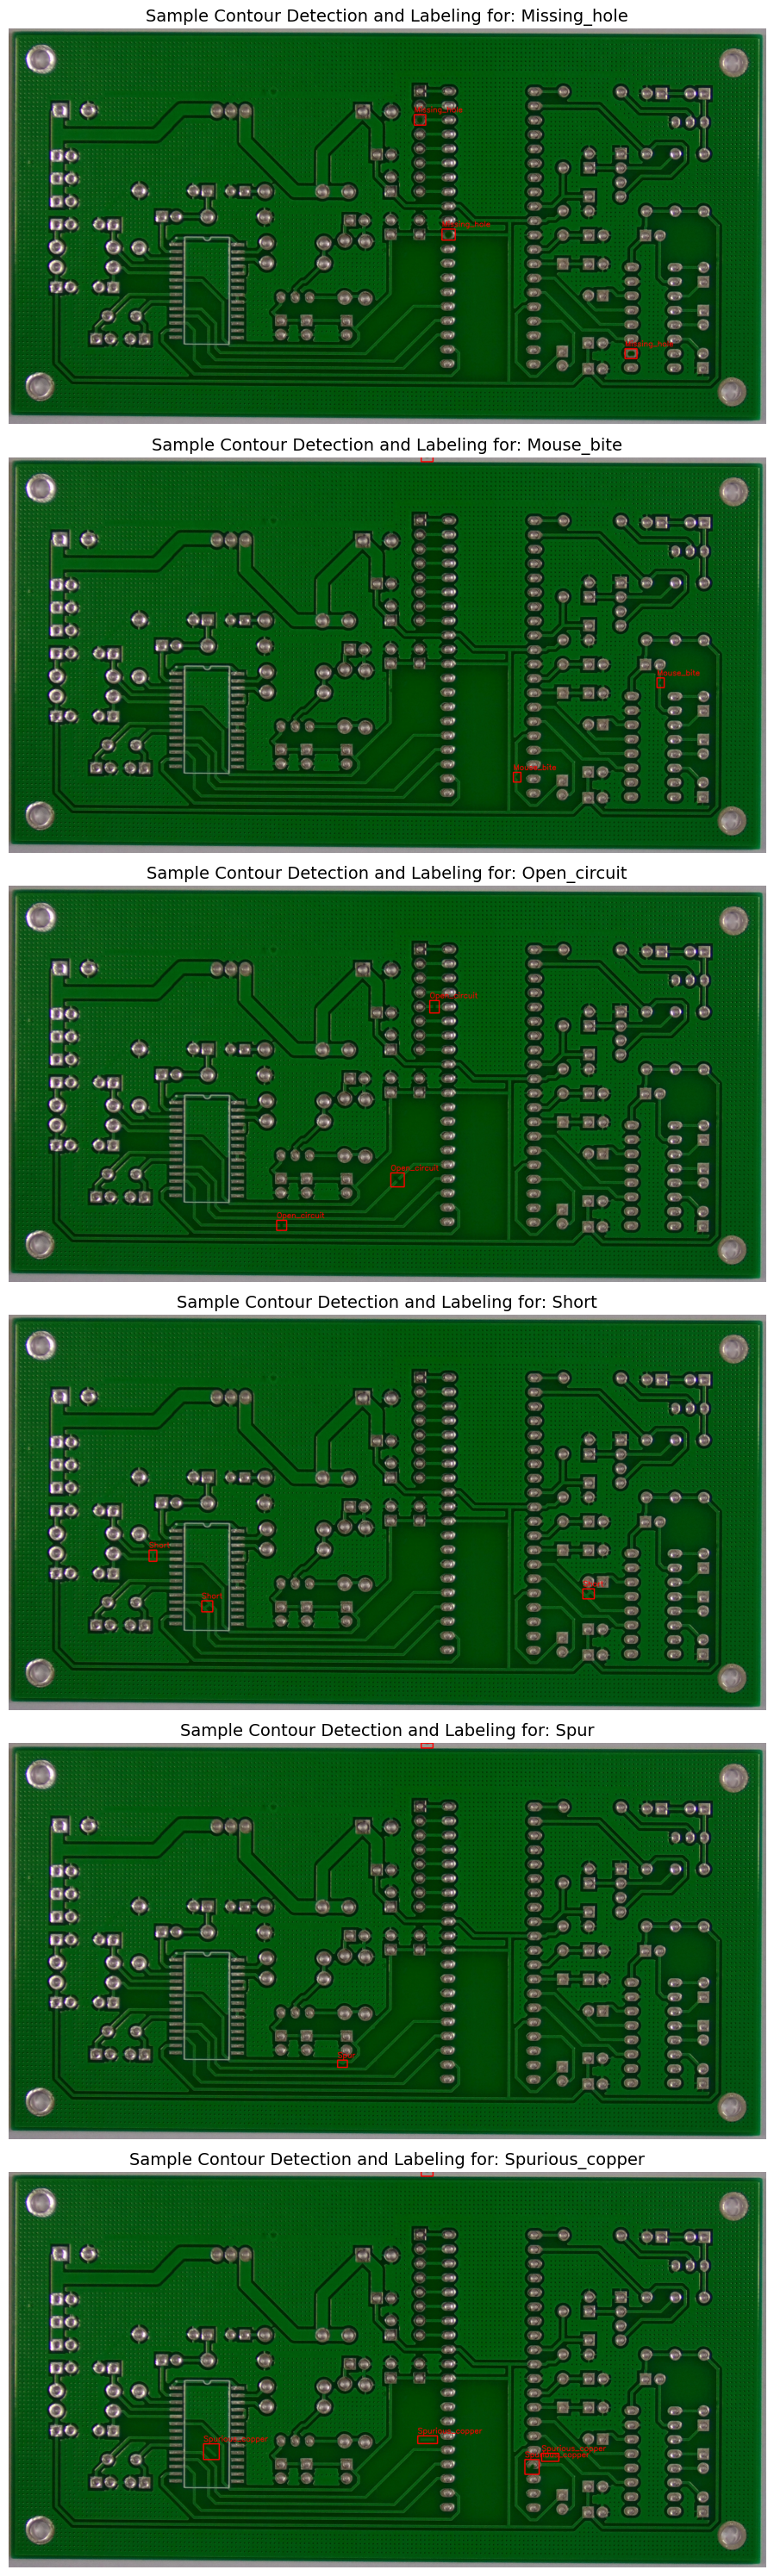

ROIs successfully cropped, labeled, resized to (128, 128), and saved to ..\Data\CLASSIFICATION_ROIS_128x128


In [ ]:


total_rois_extracted = 0
sample_visualizations = []

for defect_type in DEFECT_TYPES:
    print(f"\nStarting Contour Detection for defect type: {defect_type}")
    
    mask_dir = os.path.join(INPUT_MASKS_DIR, defect_type)
    mask_files = [f for f in os.listdir(mask_dir) if f.endswith('.png')]
    
    for mask_filename in mask_files:

        original_test_name = mask_filename.replace('MASK_', '').replace('.png', '.JPG')
        
        original_img_path = os.path.join(ORIGINAL_IMAGES_DIR, defect_type, original_test_name)
        mask_path = os.path.join(mask_dir, mask_filename)
        
   
        extracted_count, viz_output = extract_and_save_rois(mask_path, original_img_path, defect_type)
        total_rois_extracted += extracted_count


        if extracted_count > 0 and defect_type not in [s[0] for s in sample_visualizations]:
             sample_visualizations.append((defect_type, viz_output))




print(f"\n\n--- TOTAL ROIs Extracted and Saved: {total_rois_extracted} ---")
print("Displaying a sample detection result for each defect type.")

num_samples = len(sample_visualizations)
plt.figure(figsize=(20, 5 * num_samples))

for idx, (defect_type, img) in enumerate(sample_visualizations):
    if img is not None:

        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        plt.subplot(num_samples, 1, idx + 1)
        plt.imshow(img_rgb)
        plt.title(f"Sample Contour Detection and Labeling for: {defect_type}", fontsize=14)
        plt.axis('off')

plt.tight_layout()
plt.show()

print(f"ROIs successfully cropped, labeled, resized to {TARGET_SIZE}, and saved to {OUTPUT_ROIS_DIR}")